## Declare required dependencies

In [162]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Маньяк", "Убийца", "Мирный"]

## Data ingestion

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [212]:
df = pd.read_csv('/content/drive/MyDrive/Data_Analysis/Killers_with_frags.csv')
df = df.drop('Имя', axis=1)
df = df.drop('Год рождения', axis=1)
df = df.drop('Жертвы', axis=1)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

enc_ = OrdinalEncoder()
df[['Религия', 'Национальность', 'Пол']] = enc_.fit_transform(df[['Религия', 'Национальность', 'Пол']])

## Data exploration

In [213]:
df.head(5)

,Религия,Национальность,Пол,Работа,тюремное заключение,дефект речи,травма головы,Воровал,Был подвержен изнасилованию,родители наркоманы,злоупотребление наркотиками \ алкоголем,Проблемы в школе,Жил с детьми,физический дефект,посешал психолога,Были попытки самоубийства,посещал судебно-медицинскую клинику,Пойман на нарушении,Возраст первого преступления,Маньяк
0,0.0,0.0,1.0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,18,1.0
1,0.0,0.0,1.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,31,1.0
2,4.0,0.0,1.0,1,1,0,1,0,1,1,0,1,0,1,1,0,0,3,36,1.0
3,0.0,0.0,1.0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,3,28,1.0
4,0.0,0.0,1.0,0,1,0,1,1,1,0,0,0,1,1,1,0,1,1,38,1.0


In [214]:
print(df.shape)
print(df.describe())

(182, 20)
          Религия  Национальность         Пол      Работа  \
count  182.000000      182.000000  182.000000  182.000000   
mean     1.978022        0.917582    0.813187    0.351648   
std      1.932439        0.968463    0.390837    0.478802   
min      0.000000        0.000000    0.000000    0.000000   
25%      0.000000        0.000000    1.000000    0.000000   
50%      2.000000        0.000000    1.000000    0.000000   
75%      4.000000        2.000000    1.000000    1.000000   
max      4.000000        2.000000    1.000000    1.000000   

       тюремное заключение  дефект речи  травма головы     Воровал  \
count           182.000000   182.000000     182.000000  182.000000   
mean              0.450549     0.087912       0.214286    0.208791   
std               0.498921     0.283948       0.411458    0.407566   
min               0.000000     0.000000       0.000000    0.000000   
25%               0.000000     0.000000       0.000000    0.000000   
50%               0.

## Ести ли пропуски?

In [215]:
df.isnull().values.any()

False

## Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [216]:
df['Маньяк'].value_counts()

,count
Маньяк,
0.0,85
1.0,75
0.5,22


<ipython-input-217-ca9af7791d0a>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Маньяк'], sort = True)


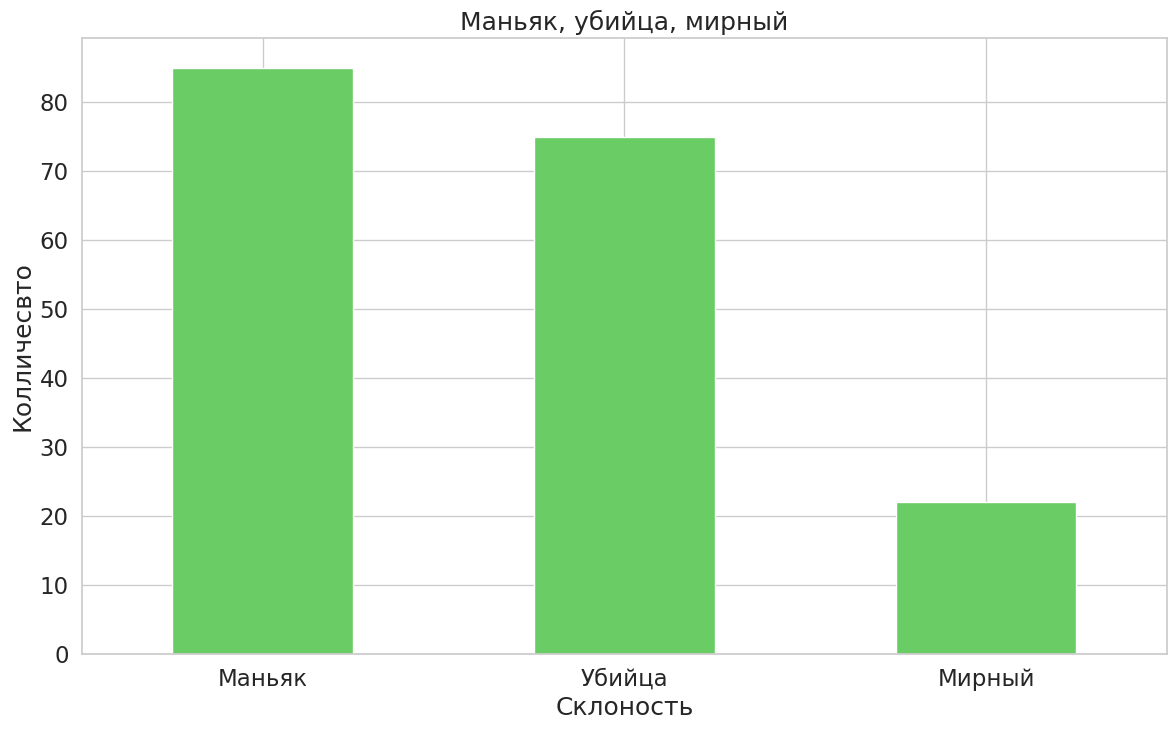

In [217]:
count_classes = pd.value_counts(df['Маньяк'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Маньяк, убийца, мирный")
plt.xticks(range(3), LABELS)
plt.xlabel("Склоность")
plt.ylabel("Колличесвто");

Наш набор данных очень сильно несбалансирован в пользу отрицательного (0, то есть нормального) класса. Это требует дальнейшего изучения данных

In [218]:
murderDF = df[df['Маньяк'] == 1]
midDF = df[df['Маньяк'] == 0.5]
normalDF = df[df['Маньяк'] == 0]

In [219]:
murderDF.shape

(75, 20)

In [220]:
normalDF.shape

(85, 20)

In [221]:
midDF.shape

(22, 20)

Давайте теперь посмотрим на сумму денег, задействованную в двух классах.

In [222]:
murderDF['Возраст первого преступления'].describe()

,Возраст первого преступления
count,75.000000
mean,31.000000
std,8.577154
min,14.000000
25%,26.000000
50%,30.000000
75%,35.000000
max,66.000000


In [223]:
normalDF['Возраст первого преступления'].describe()

,Возраст первого преступления
count,85.000000
mean,3.129412
std,8.504604
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,40.000000


In [224]:
midDF['Возраст первого преступления'].describe()

,Возраст первого преступления
count,22.000000
mean,27.681818
std,15.566712
min,0.000000
25%,19.750000
50%,25.000000
75%,34.500000
max,71.000000


Graphically speaking ...`

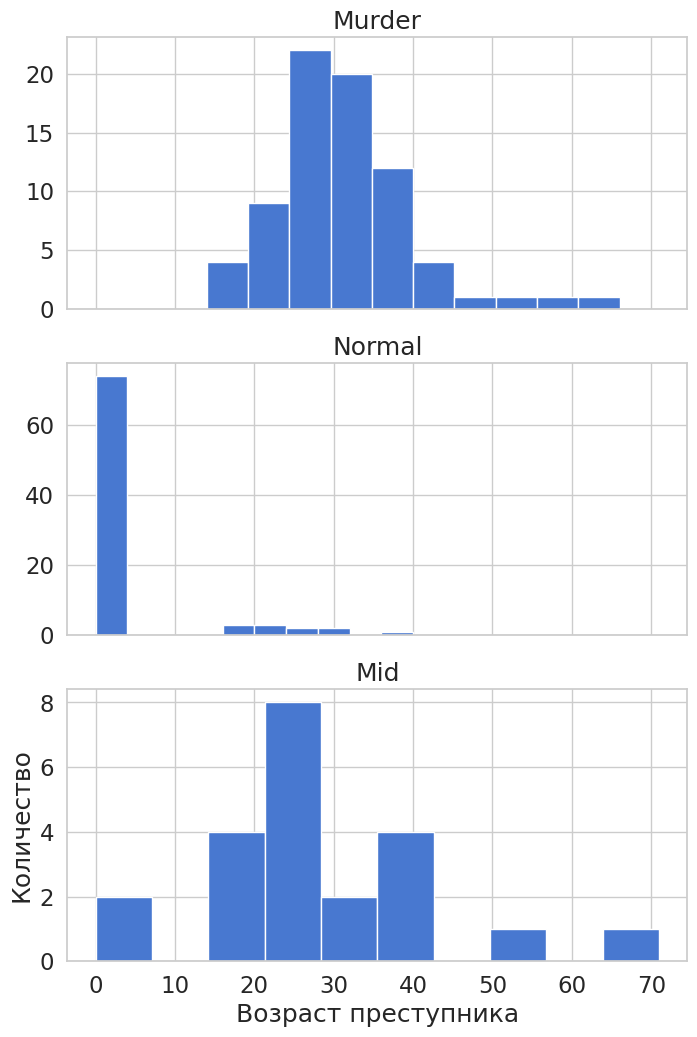

In [225]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

bins = 10

ax1.hist(murderDF['Возраст первого преступления'], bins=bins)
ax1.set_title('Murder')

ax2.hist(normalDF['Возраст первого преступления'], bins=bins)
ax2.set_title('Normal')

ax3.hist(midDF['Возраст первого преступления'], bins=bins)
ax3.set_title('Mid')

plt.xlabel('Возраст преступника')
plt.ylabel('Количество')
plt.show()


Влияет ли время транзакции на мошеннические транзакции?

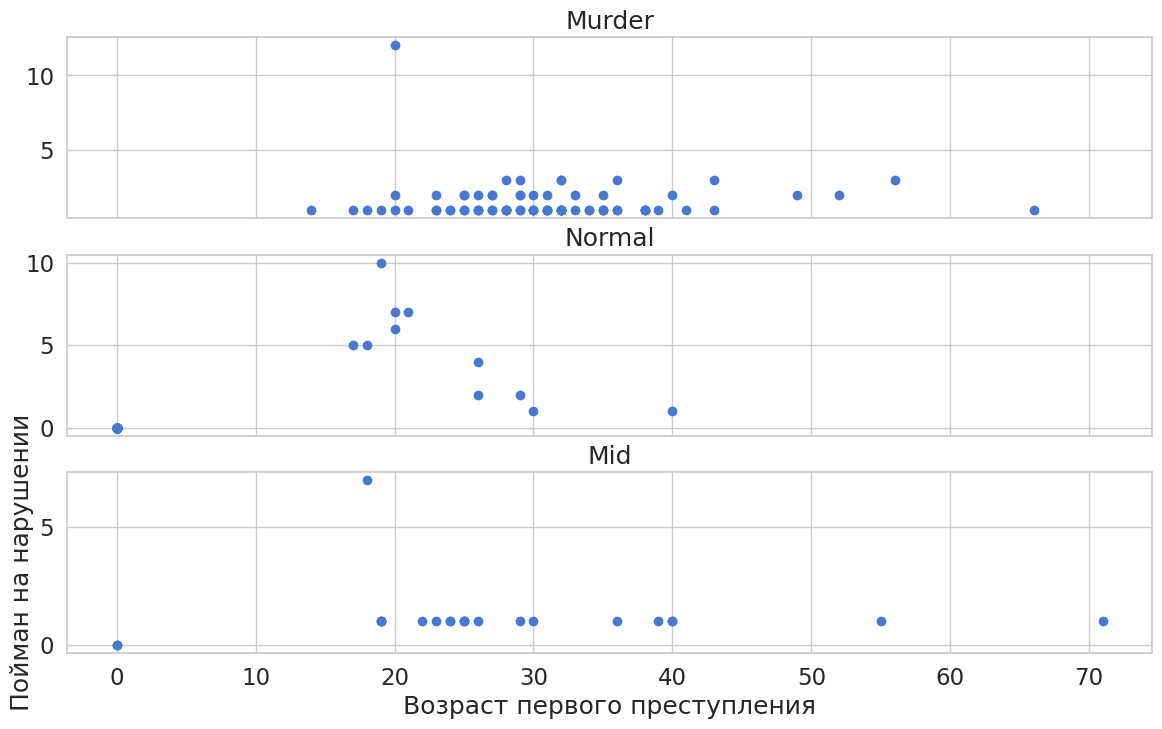

In [226]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.scatter(murderDF['Возраст первого преступления'], murderDF['Пойман на нарушении'])
ax1.set_title('Murder')

ax2.scatter(normalDF['Возраст первого преступления'], normalDF['Пойман на нарушении'])
ax2.set_title('Normal')

ax3.scatter(midDF['Возраст первого преступления'], midDF['Пойман на нарушении'])
ax3.set_title('Mid')

plt.xlabel('Возраст первого преступления')
plt.ylabel('Пойман на нарушении')
plt.show()

## Preprocessing

Поскольку, как показано выше, время транзакции не влияет на мошенническую деятельность, эта функция не будет способствовать обучению модели. Следовательно, мы можем отказаться от него.

In [227]:
transactionData = df.drop(['Пойман на нарушении'], axis=1)

Также давайте стандартизируем Amount.

In [228]:
transactionData['Возраст первого преступления'] = StandardScaler().fit_transform(transactionData['Возраст первого преступления'].values.reshape(-1, 1))

In [229]:
transactionData.describe()

,Религия,Национальность,Пол,Работа,тюремное заключение,дефект речи,травма головы,Воровал,Был подвержен изнасилованию,родители наркоманы,злоупотребление наркотиками \ алкоголем,Проблемы в школе,Жил с детьми,физический дефект,посешал психолога,Были попытки самоубийства,посещал судебно-медицинскую клинику,Возраст первого преступления,Маньяк
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,1.820000e+02,182.000000
mean,1.978022,0.917582,0.813187,0.351648,0.450549,0.087912,0.214286,0.208791,0.379121,0.192308,0.543956,0.813187,0.175824,0.296703,0.258242,0.082418,0.137363,-1.561632e-16,0.472527
std,1.932439,0.968463,0.390837,0.478802,0.498921,0.283948,0.411458,0.407566,0.486507,0.395201,0.499438,0.390837,0.381721,0.458065,0.438875,0.275758,0.345179,1.002759e+00,0.469293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.059622e+00,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.059622e+00,0.000000
50%,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.456980e-01,0.500000
75%,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.483580e-01,1.000000
max,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.219264e+00,1.000000


### Разделите набор данных на наборы обучающих и тестовых данных.

Мы разделили набор данных как обучение = 80% и тест = 20%. В обучающем наборе данных будут только обычные транзакции, а в тестовом наборе данных будут как обычные, так и мошеннические транзакции.

In [233]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.drop(['Маньяк'], axis=1)
#print(type(X_train))
y_test = X_test['Маньяк']
X_test = X_test.drop(['Маньяк'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)


37


## Model
Мы построим автоэнкодер, состоящий из 4 полносвязных слоев с 14,7,7,29 нейронами. Первые 2 слоя действуют как кодировщик, а последние 2 слоя действуют как декодер. Обратите внимание, что последний слой имеет 29 узлов, соответствующих 29 функциям в элементе входных данных.

In [272]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(18, 128),  # Входные данные размерностью 18 (после удаления двух столбцов)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 18)  # Размерность на выходе - 18 (после удаления двух столбцов)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [273]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [274]:
num_epochs = 5000   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 16
learning_rate = 1e-6

**minibatch_size** - размер мини-пакета - это количество записей (или векторов), которые мы одновременно передаем в наш алгоритм обучения. Отношение между тем, насколько быстро наш алгоритм может обучить модель, обычно имеет U-образную форму (размер пакета в зависимости от скорости обучения). Это означает, что первоначально по мере увеличения размера партии время обучения будет уменьшаться. В конце концов  мы увидим, что время обучения начинает увеличиваться, когда мы превышаем определенный размер пакета, который слишком велик.
По мере увеличения размера мини-пакета большее количество вычислений означает, что градиенты могут быть более плавными, но их вычисление требует больших затрат. В идеале каждая мини-партия, на которой проводится обучение, должна содержать пример каждого класса, чтобы уменьшить ошибку выборки при оценке градиента для всей обучающей выборки.


**learning_rate** - скорость оптимизации (обучения). Насколько маленькими шашами мы изменяем градиент.

In [275]:

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)


In [276]:

#test = data_utils.TensorDataset(torch.from_numpy(X_test).double(),torch.from_numpy(y_test).double())
#test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [277]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)


In [278]:
history = {}
history['train_loss'] = []
history['test_loss'] = []


In [279]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/5000], loss:0.8290
epoch [2/5000], loss:0.8074
epoch [3/5000], loss:0.8747
epoch [4/5000], loss:0.9150
epoch [5/5000], loss:0.8105
epoch [6/5000], loss:0.7994
epoch [7/5000], loss:0.8286
epoch [8/5000], loss:0.8050
epoch [9/5000], loss:0.9101
epoch [10/5000], loss:0.7953
epoch [11/5000], loss:0.8068
epoch [12/5000], loss:0.8743
epoch [13/5000], loss:0.8889
epoch [14/5000], loss:0.9097
epoch [15/5000], loss:0.8900
epoch [16/5000], loss:0.8200
epoch [17/5000], loss:0.8097
epoch [18/5000], loss:0.8266
epoch [19/5000], loss:0.8091
epoch [20/5000], loss:0.9093
epoch [21/5000], loss:0.8999
epoch [22/5000], loss:0.8196
epoch [23/5000], loss:0.8049
epoch [24/5000], loss:0.9008
epoch [25/5000], loss:0.8880
epoch [26/5000], loss:0.8838
epoch [27/5000], loss:0.8273
epoch [28/5000], loss:0.8183
epoch [29/5000], loss:0.8194
epoch [30/5000], loss:0.9039
epoch [31/5000], loss:0.8875
epoch [32/5000], loss:0.8263
epoch [33/5000], loss:0.7930
epoch [34/5000], loss:0.8350
epoch [35/5000], loss:0

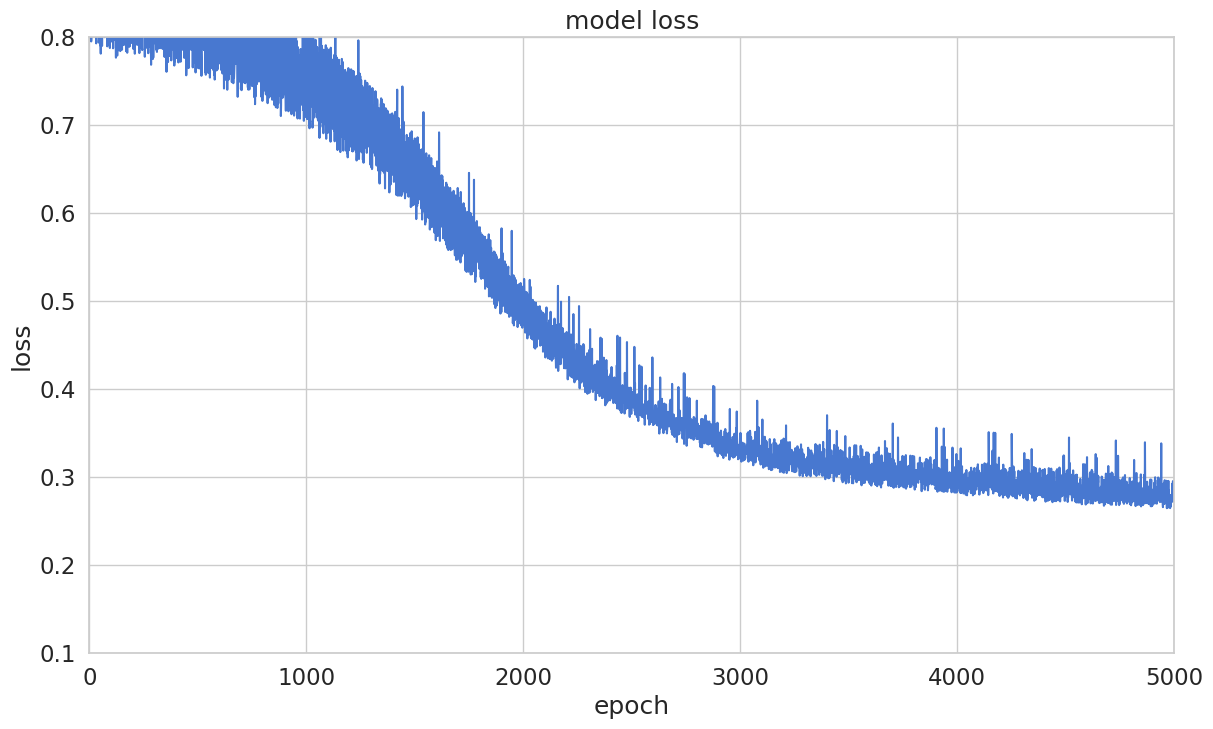

In [282]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,5000,0.10,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Оценка модели

In [283]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [293]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,37.000000,37.000000
mean,0.314885,0.500000
std,0.138944,0.485913
min,0.092676,0.000000
25%,0.237064,0.000000
50%,0.290364,0.500000
75%,0.381057,1.000000
max,0.861172,1.000000


In [294]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,37.000000,37.000000
mean,0.314885,0.500000
std,0.138944,0.485913
min,0.092676,0.000000
25%,0.237064,0.000000
50%,0.290364,0.500000
75%,0.381057,1.000000
max,0.861172,1.000000


# Reconstruction Errors without Fraud

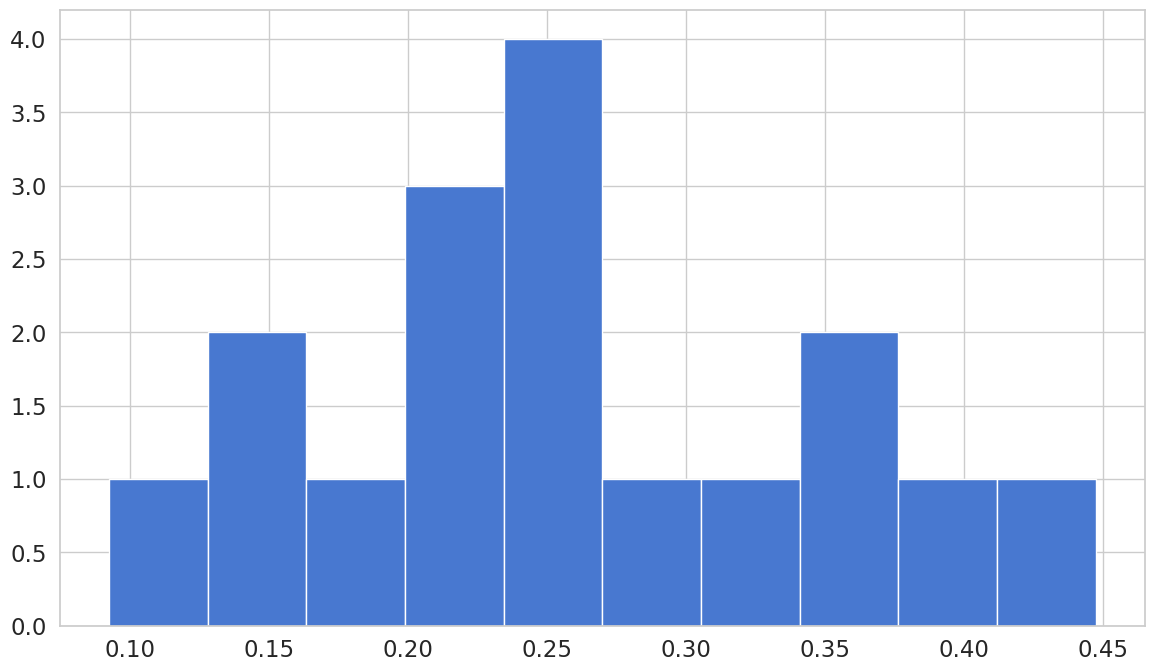

In [295]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

# Reconstruction Errors with Fraud

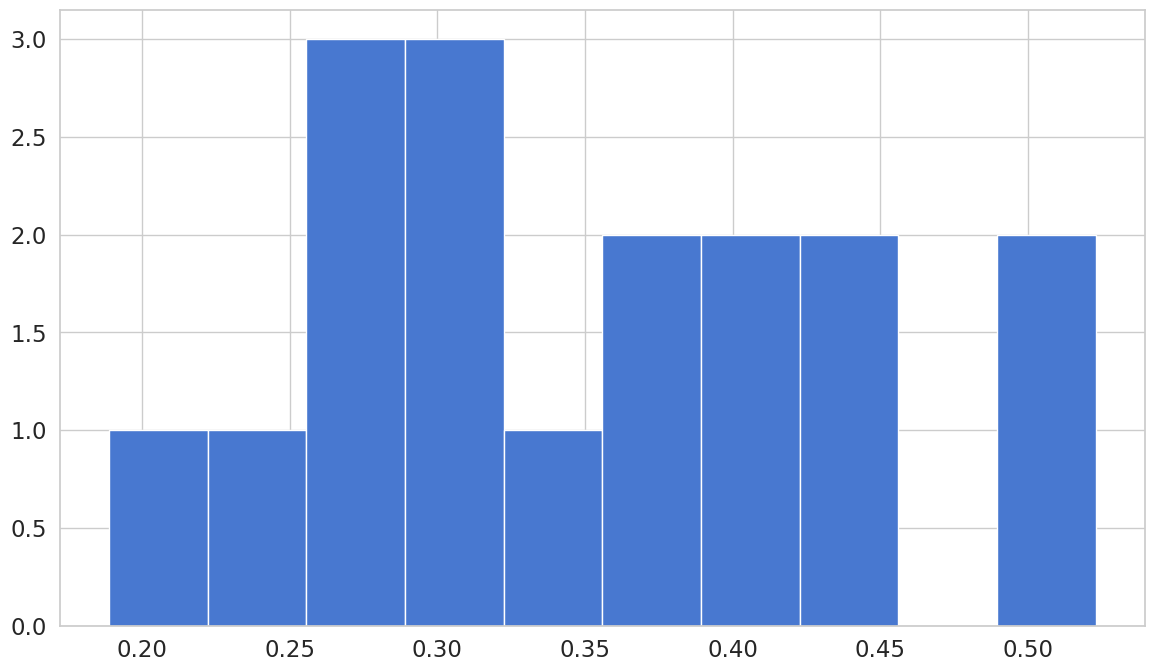

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

## ROC Curves

ROC-кривая очень часто используется для анализа бинарных классификаторов. Он рассматривает все возможные пороговые значения для данного классификатора и показывает процент ложных срабатываний (FPR) по сравнению с показателями истинно положительных результатов (TPR).

In [300]:
reconstructionErrorDF['Class'].unique()

array([1. , 0. , 0.5])

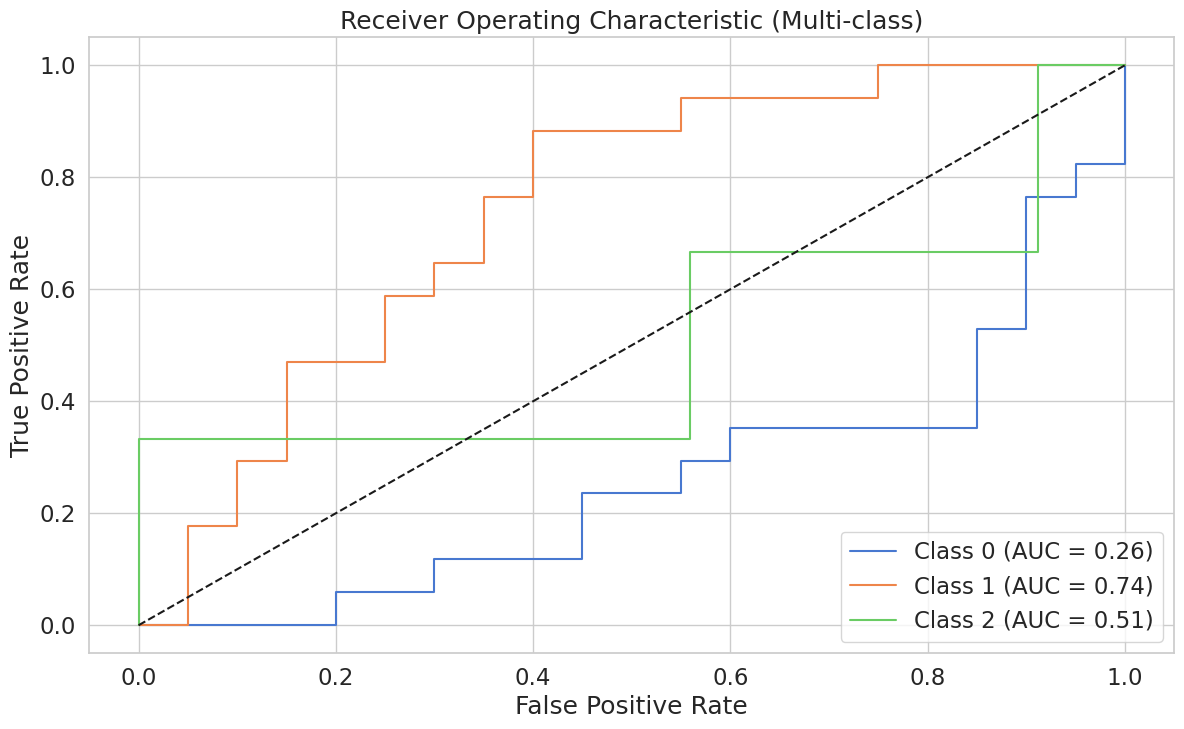

In [303]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Преобразуем метки в целочисленные категории
reconstructionErrorDF['Class'] = reconstructionErrorDF['Class'].apply(lambda x: 0 if x == 0.0 else (1 if x == 1.0 else 2))

# Преобразуем в бинарный формат для One-vs-Rest
n_classes = len(reconstructionErrorDF['Class'].unique())  # Количество классов
y_bin = label_binarize(reconstructionErrorDF['Class'], classes=[0, 1, 2])

# Нормализуем потери для предсказанных вероятностей
max_loss = max(reconstructionErrorDF['pred_loss'])
min_loss = min(reconstructionErrorDF['pred_loss'])
pred_probabilities = [(loss - min_loss) / (max_loss - min_loss) for loss in reconstructionErrorDF['pred_loss']]

# Инициализация переменных для AUC и ROC
fpr = {}
tpr = {}
roc_auc = {}

# Вычисляем ROC для каждого класса
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], pred_probabilities)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение графиков ROC кривых
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Receiver Operating Characteristic (Multi-class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## Precision vs Recall

Установка порога, который используется для принятия решения о классификации в модели, — это способ настроить компромисс между точностью (precision) и полнотой (recall) для данного классификатора.

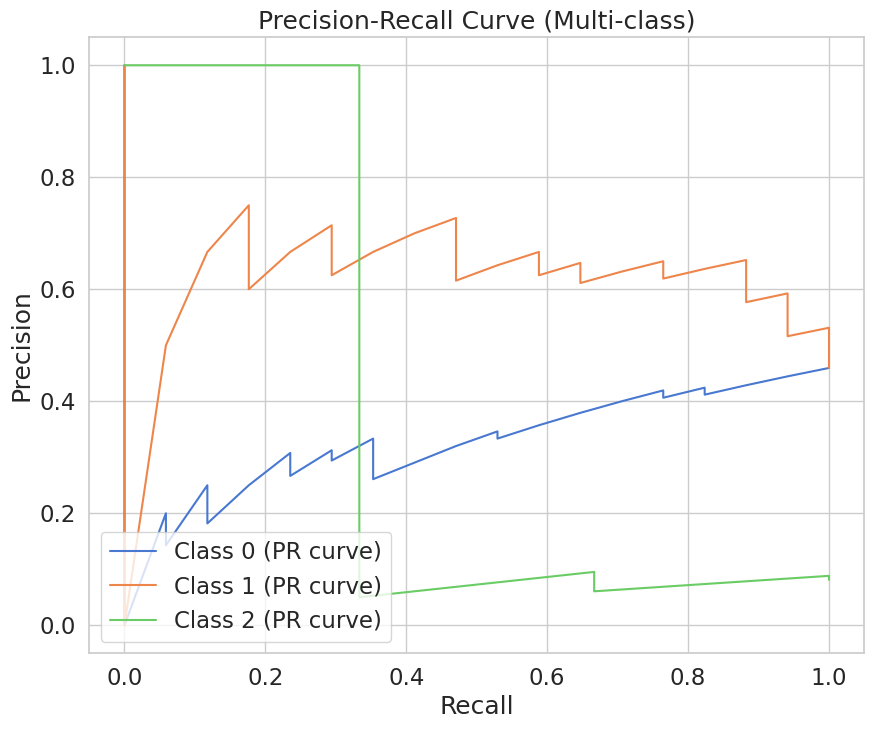

In [304]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Преобразуем метки в целочисленные категории
reconstructionErrorDF['Class'] = reconstructionErrorDF['Class'].apply(lambda x: 0 if x == 0.0 else (1 if x == 1.0 else 2))

# Преобразуем метки в бинарный формат для One-vs-Rest
n_classes = len(reconstructionErrorDF['Class'].unique())  # Количество классов
y_bin = label_binarize(reconstructionErrorDF['Class'], classes=[0, 1, 2])

# Нормализуем потери для предсказанных вероятностей
max_loss = max(reconstructionErrorDF['pred_loss'])
min_loss = min(reconstructionErrorDF['pred_loss'])
pred_probabilities = [(loss - min_loss) / (max_loss - min_loss) for loss in reconstructionErrorDF['pred_loss']]

# Вычисляем precision и recall для каждого класса
precision = {}
recall = {}
thresholds = {}

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_bin[:, i], pred_probabilities)

# Построение Precision-Recall кривых
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (PR curve)')

plt.title('Precision-Recall Curve (Multi-class)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()


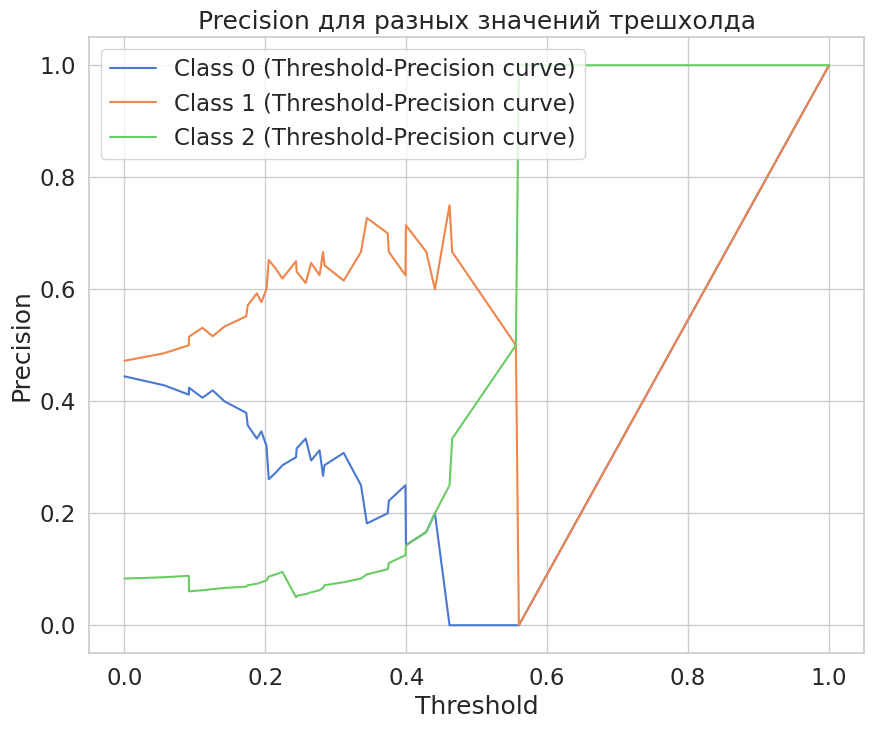

In [305]:
import matplotlib.pyplot as plt

# Построение Precision-Threshold кривых для каждого класса
plt.figure(figsize=(10, 8))

# Перебираем каждый класс
for i in range(n_classes):
    plt.plot(thresholds[i], precision[i][1:], label=f'Class {i} (Threshold-Precision curve)')

plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()


Вы можете видеть, что по мере увеличения ошибки реконструкции повышается и наша precision. Давайте посмотрим на recall:


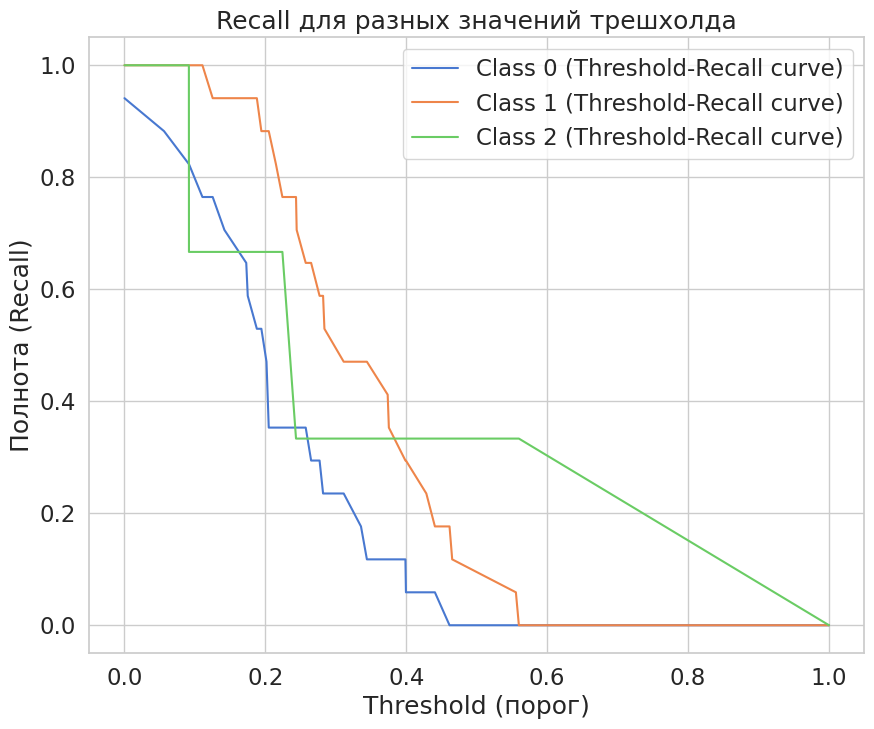

In [307]:
import matplotlib.pyplot as plt

# Построение Recall-Threshold кривых для каждого класса
plt.figure(figsize=(10, 8))

# Перебираем каждый класс и строим кривую Recall для разных значений порога
for i in range(n_classes):
    plt.plot(thresholds[i], recall[i][1:], label=f'Class {i} (Threshold-Recall curve)')

plt.title('Recall для разных значений трешхолда')
plt.xlabel('Threshold (порог)')
plt.ylabel('Полнота (Recall)')
plt.legend(loc='best')
plt.show()


Здесь мы имеем прямо противоположную ситуацию. По мере увеличения ошибки реконструкции recall (полнота) уменьшается.

## Используем модель для того, чтобы сделать предсказание

Чтобы предсказать, является ли новая/невидимая транзакция нормальной или мошеннической, мы рассчитаем ошибку реконструкции на основе самих данных транзакции. Если ошибка превышает предопределенный порог, мы помечаем ее как мошенничество (поскольку наша модель должна иметь низкую ошибку при обычных транзакциях). Давайте выберем это значение:

In [316]:
threshold = 0.2

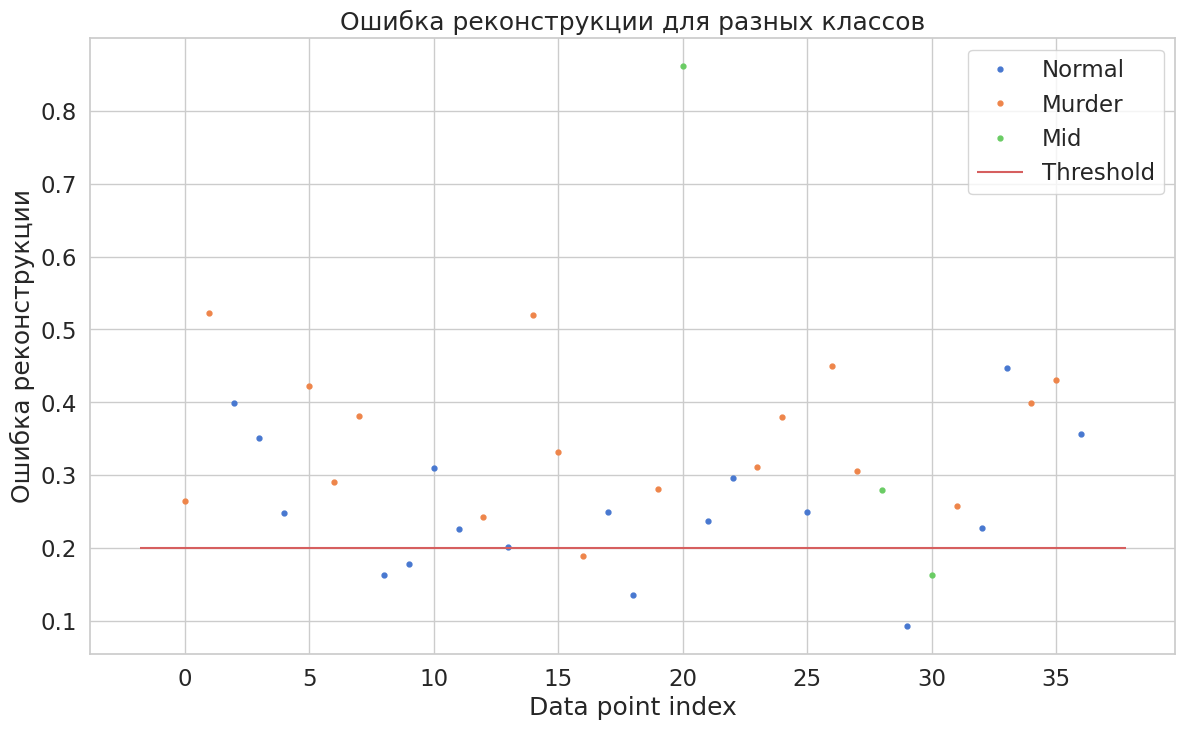

In [317]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Murder" if name == 1 else "Normal" if name == 0 else "Mid")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

Построим и посмотрим confusion matrix:

<ipython-input-318-11f70cc5c840>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


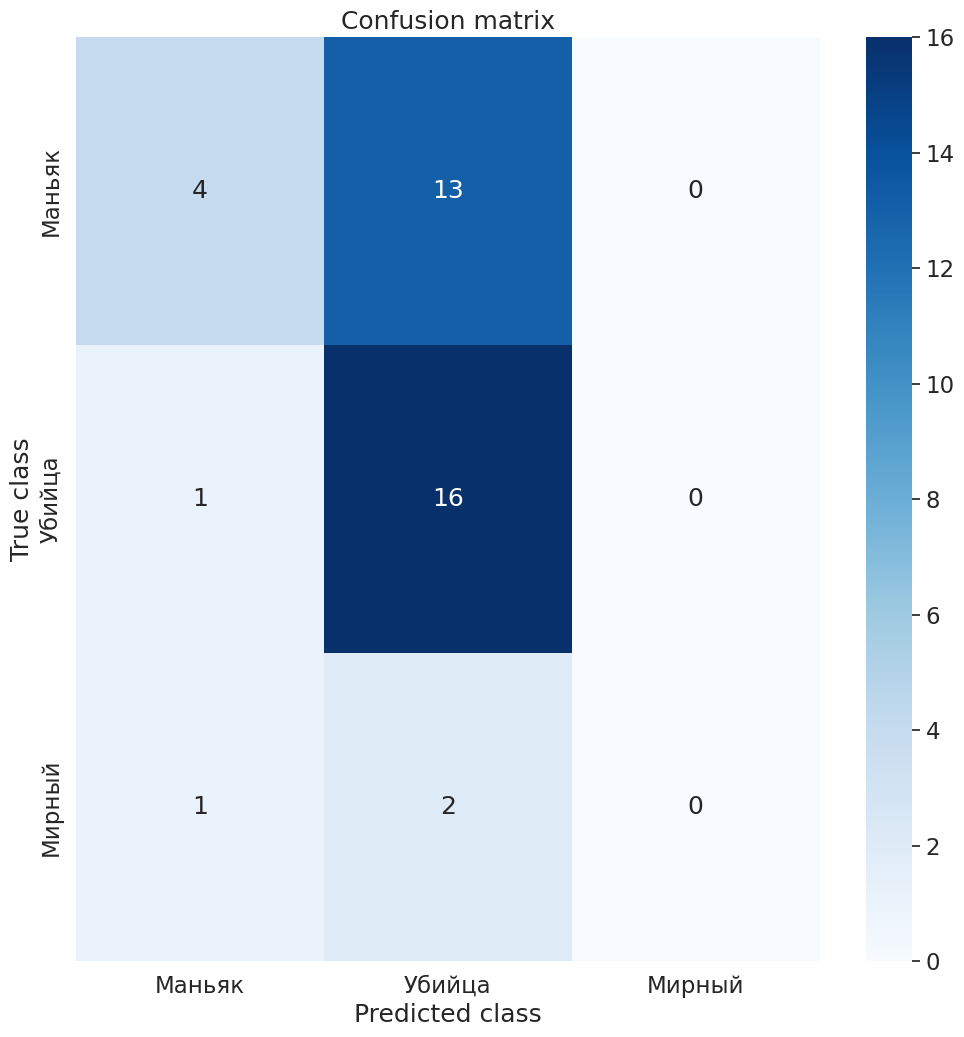

In [318]:

y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Наша модель, похоже, выявляет множество случаев мошенничества. Но количество обычных транзакций, классифицируемых как мошенничество, действительно велико. Можно настроить порог здесь и там, чтобы получить лучшие результаты.

## Выводы


Мы создали очень простой Deep Autoencoder в PyTorch, который может реконструировать, как выглядят немошеннические транзакции. Он научился распознавать немошеннические транзакции, изучая некоторые шаблоны, присутствующие в этих транзакциях, и что это за шаблоны, о которых трудно сказать — загадка любой нейронной сети с глубоким обучением.

PyTorch предоставил нам очень понятный и простой в использовании API для создания нетривиального Deep Autoencoder. Можно попытаться создать аналогичный автоэнкодер, используя другую структуру, например Tensorflow/Keras/fast.ai, для другого домена/проблемы, например, классифицировать изображения как содержащие неприемлемый контент.